# Setup

In [80]:
import os
import numpy as np
import random
import pandas as pd
import tensorflow as tf
import math
import operator
from collections import defaultdict
from matplotlib import pyplot as plt

In [2]:
TRAIN_PATH = os.environ['TRAINING_DATA_LOCATION']
TEST_PATH = os.environ['TEST_DATA_LOCATION']

# Load data

In [3]:
train_df = pd.read_csv(os.path.join(TRAIN_PATH, 'train.csv'), parse_dates=['date'],index_col='id')
train_df

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148


In [4]:
test_df = pd.read_csv(os.path.join(TEST_PATH, 'test.csv'), parse_dates=['date'], index_col='id')
test_df

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1
3029396,2017-08-31,9,PREPARED FOODS,0
3029397,2017-08-31,9,PRODUCE,1


For now we are only interested in the bare-bone data about sales, ignoring additional CSV files.

# Check for missing values

In [6]:
train_df.isna().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

There are no missing values in the train dataframe.

In [7]:
test_df.isnull().sum()

date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Thare are no missing values in the test dataframe.

# How many different stores do we have?

In [8]:

train_df.store_nbr.nunique()

54

We have `54` different stores.

In [9]:
# Check if the stores from test set are in the training set
train_stores = set(train_df.store_nbr.unique())
test_stores = set(test_df.store_nbr.unique())
assert test_stores <= train_stores

All the stores from the test set are also in the train set.

# How many different categories of products do we have?

In [11]:
train_df.family.nunique()

33

# Average sales for different stores

Text(0.5, 1.0, 'Sales by store histogram')

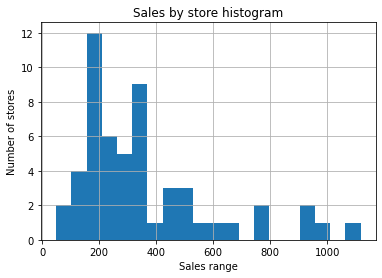

In [29]:
train_df.groupby('store_nbr').agg({'sales': 'mean'}).hist(bins=20)
# set plot x label
plt.xlabel('Sales range')
# set plot y label
plt.ylabel('Number of stores')
# set plot title
plt.title('Sales by store histogram')

# Average sales for different product families

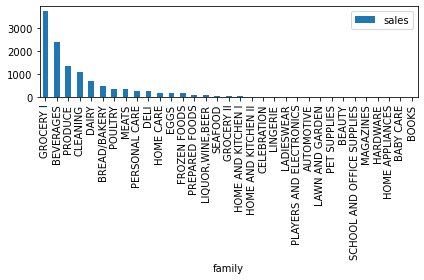

In [36]:
train_df.groupby('family').agg({'sales': 'mean'}).sort_values('sales', ascending=False).plot.bar()
plt.tight_layout()

The most surprising thing is that the average sales for baby care products are so low.

# Let's see how much data do we have by date

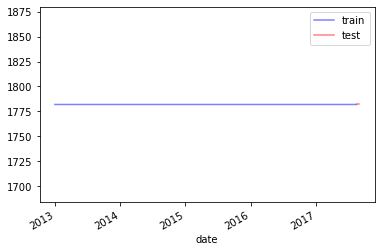

In [48]:
train_df.groupby('date').sales.count().plot(kind='line', label='train', color='blue', alpha=0.5)
test_df.groupby('date').store_nbr.count().plot(kind='line', label='test', color='red', alpha=0.5)
_ = plt.legend()

Seems that our data is evenly distributed by date.

# Look for trends in sales samples

In [58]:
# group by store and product family
grouped_df = train_df.groupby(['store_nbr', 'family'])

In [59]:
# salect random subset of grouping keys
sample_groups = random.sample(grouped_df.groups.keys(), 10)
sample_groups

[(44, 'EGGS'),
 (27, 'GROCERY I'),
 (9, 'LADIESWEAR'),
 (9, 'BEAUTY'),
 (23, 'LADIESWEAR'),
 (39, 'BREAD/BAKERY'),
 (14, 'PERSONAL CARE'),
 (12, 'BOOKS'),
 (10, 'PERSONAL CARE'),
 (17, 'LINGERIE')]

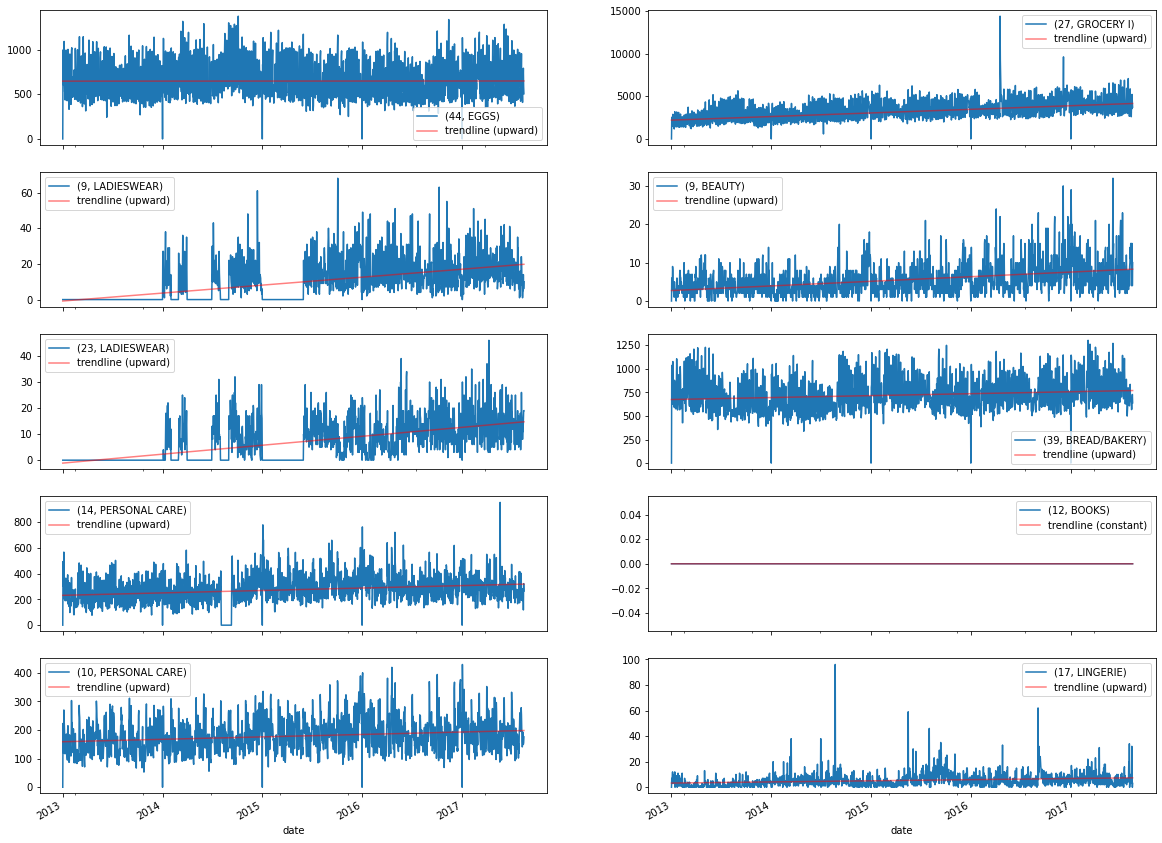

In [76]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 16), sharex=True)
for ax, grouping_key in zip(axes.ravel(), sample_groups):
    data = grouped_df.get_group(grouping_key)

    trendline_coefficients = np.polyfit(x=data.date.map(pd.Timestamp.timestamp), y=data.sales, deg=1)
    a, b = trendline_coefficients
    trendline_polynomial = np.poly1d(trendline_coefficients)

    trend_indicator = {-1: 'downward', +1: 'upward', 0: 'constant'}[np.sign(a)]

    data.plot(x='date', y='sales', kind='line', ax=ax, label=grouping_key)
    ax.plot(data.date, trendline_polynomial(data.date.map(pd.Timestamp.timestamp)), 'r-', label=f'trendline ({trend_indicator})', alpha=0.5)

    ax.legend()


We can observe a slight upward trend in sales of most product families.
Nobody seems to be buying books.

A more worrying insight is that there are some periods where the shops are selling zero items.

We should investigate if this is something across multiple stores or across categories.

# Investigate ladiesware sales across shops

In [79]:
ladieswear = train_df[train_df.family == 'LADIESWEAR'].groupby('store_nbr')
num_shops = len(ladieswear.groups)
num_shops

54

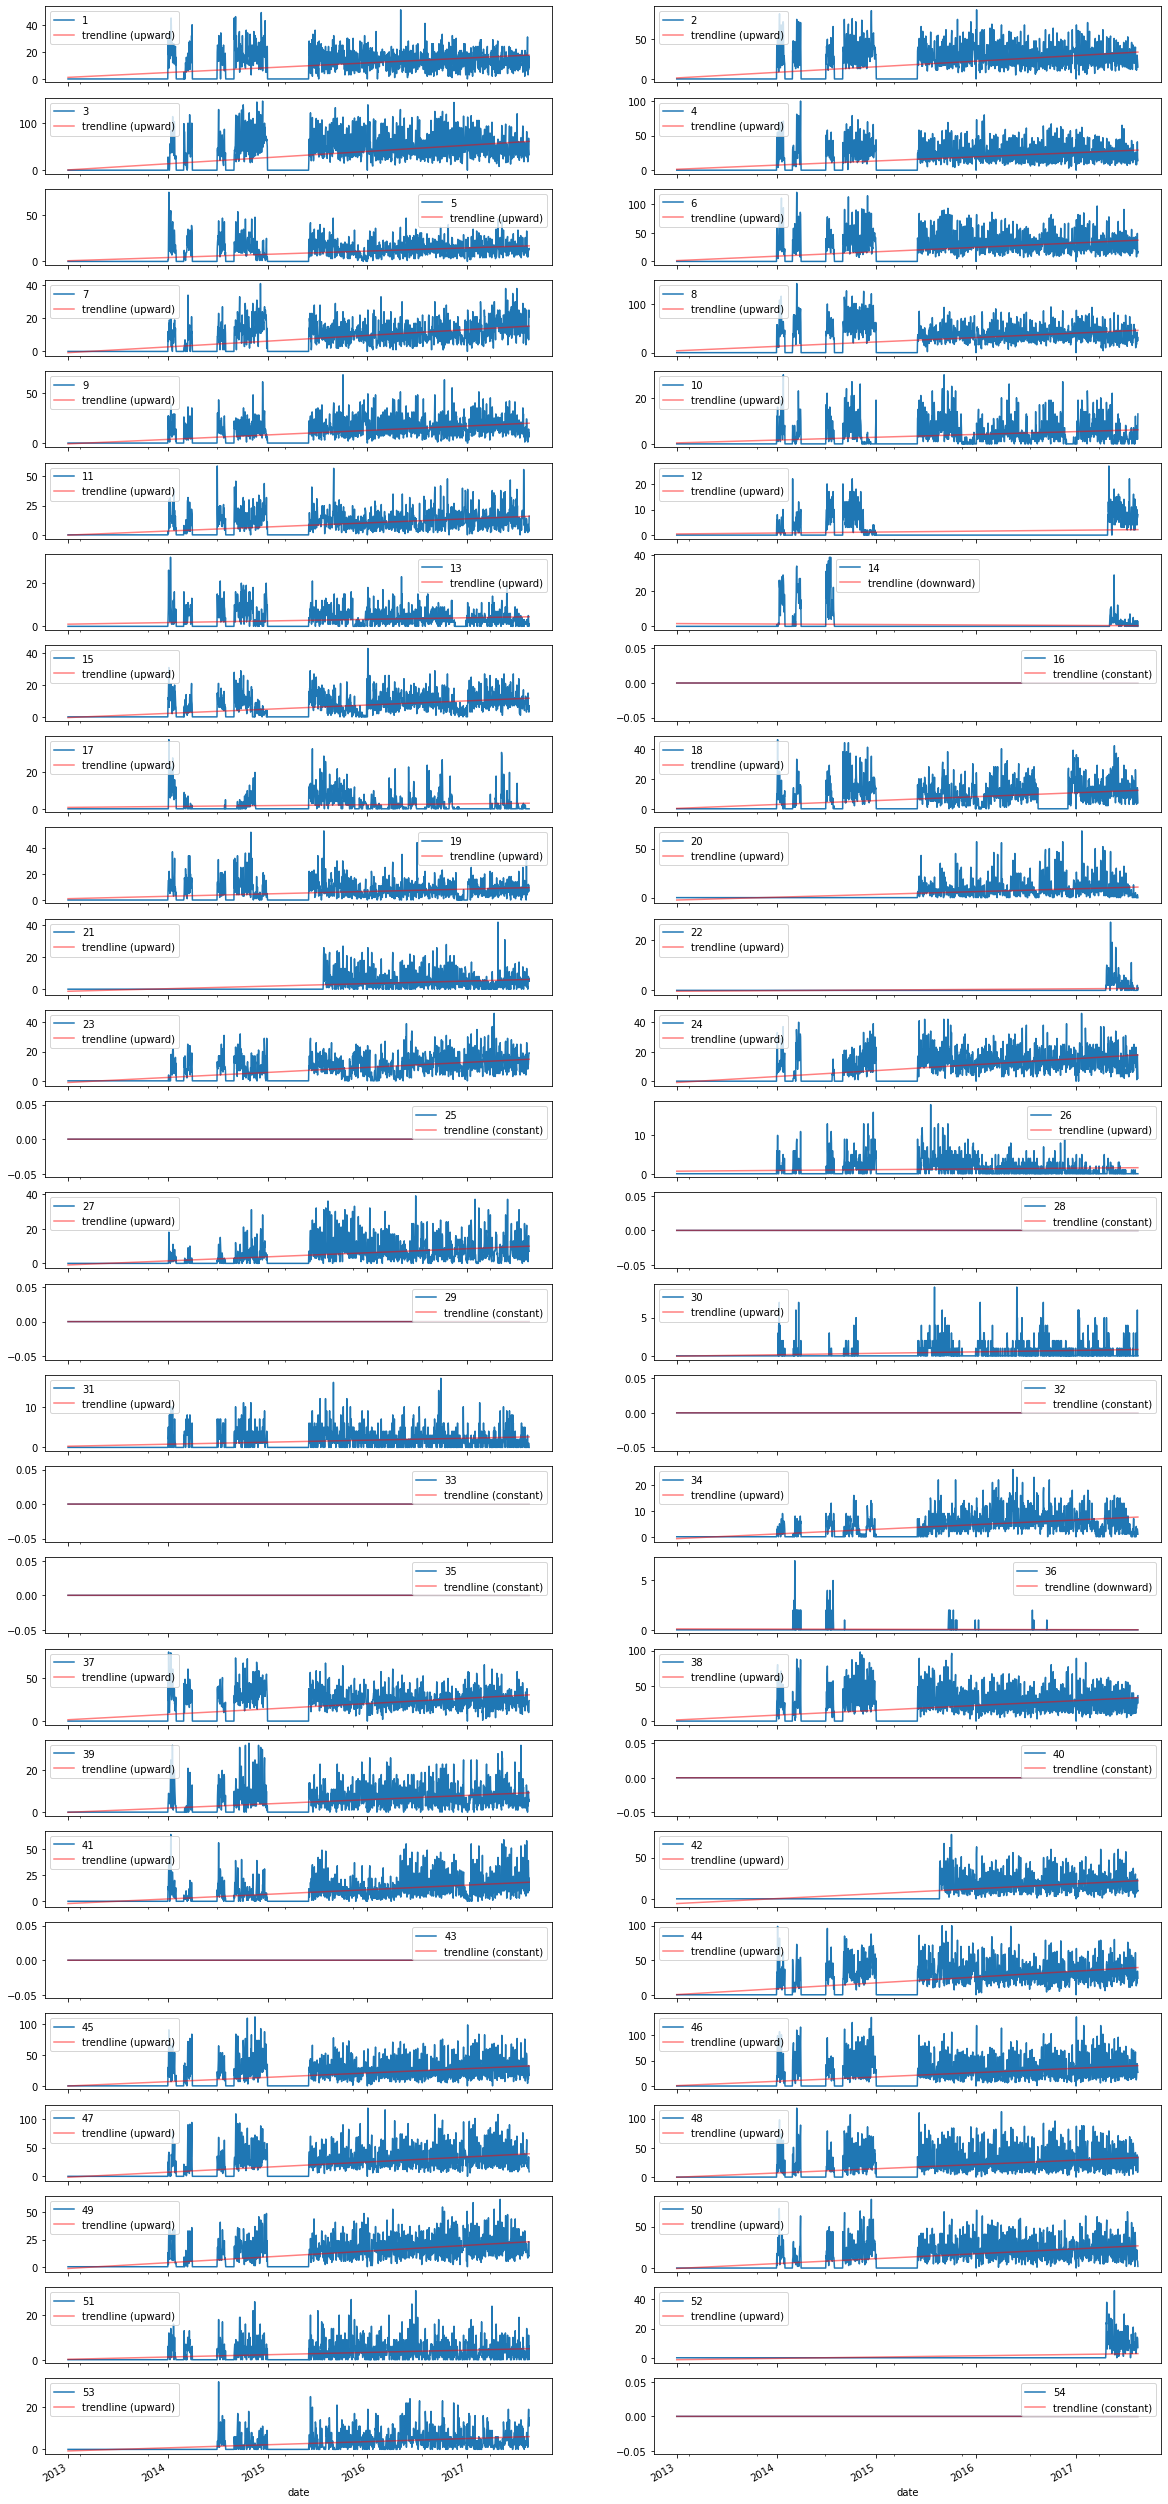

In [84]:
fig, axes = plt.subplots(nrows=math.ceil(num_shops / 2), ncols=2, figsize=(20, 50), sharex=True)
for ax, grouping_key in zip(axes.ravel(), ladieswear.groups.keys()):
    data = ladieswear.get_group(grouping_key)

    trendline_coefficients = np.polyfit(x=data.date.map(pd.Timestamp.timestamp), y=data.sales, deg=1)
    a, b = trendline_coefficients
    trendline_polynomial = np.poly1d(trendline_coefficients)

    trend_indicator = {-1: 'downward', +1: 'upward', 0: 'constant'}[np.sign(a)]

    data.plot(x='date', y='sales', kind='line', ax=ax, label=grouping_key)
    ax.plot(data.date, trendline_polynomial(data.date.map(pd.Timestamp.timestamp)), 'r-', label=f'trendline ({trend_indicator})', alpha=0.5)

    ax.legend()